In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',1000)

path_train = "drive/MyDrive/Colab Notebooks/train.csv"
path_test = "drive/MyDrive/Colab Notebooks/test.csv"
path_spray = "drive/MyDrive/Colab Notebooks/spray.csv"
path_weather = "drive/MyDrive/Colab Notebooks/weather.csv"
path_sample = "drive/MyDrive/Colab Notebooks/sampleSubmission.csv"

train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)
spray_df = pd.read_csv(path_spray)
weather_df = pd.read_csv(path_weather)

# Preprocessing

## Preprocess weather datasets

In [3]:
# On remplace les données manquantes ('M', '-') par None
weather_df.replace(['M', '-'], np.nan, inplace=True)
print(weather_df.isnull().sum())

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64


In [4]:
# Remplacer NaN par la moyenne de chaque colonne
col = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
for column in col:
        weather_df[column] = pd.to_numeric(weather_df[column], errors='coerce')
        mean_value = weather_df[column].mean()
        weather_df[column].fillna(mean_value, inplace=True)

# Features gênantes pour l'entrainement du modèle (de type object) pourront potentiellement être ajoutée après
weather_df = weather_df.drop(['Water1', 'CodeSum'], axis=1)
# Vérification qu'il n'y a plus de valeurs non définie
print(weather_df.isnull().sum())

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
Depth          0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64


## Preprocess train dataset

In [5]:
target = train_df['WnvPresent']
target

0        0
1        0
2        0
3        0
4        0
        ..
10501    1
10502    0
10503    0
10504    0
10505    0
Name: WnvPresent, Length: 10506, dtype: int64

In [6]:
train = train_df.drop(["WnvPresent", "Address", "AddressNumberAndStreet", "Street", "Trap", "NumMosquitos"], axis=1)

station1 = (41.995, -87.933)
station2 = (41.786, -87.752)

def euclidean_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

def closest_station(row):
    dist_to_station1 = euclidean_distance(row['Latitude'], row['Longitude'], station1[0], station1[1])
    dist_to_station2 = euclidean_distance(row['Latitude'], row['Longitude'], station2[0], station2[1])
    return 1 if dist_to_station1 < dist_to_station2 else 2

train['Station'] = train.apply(closest_station, axis=1)

train = train.drop(["Latitude", "Longitude"], axis=1)

train

,Date,Species,Block,AddressAccuracy,Station
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,9,1
1,2007-05-29,CULEX RESTUANS,41,9,1
2,2007-05-29,CULEX RESTUANS,62,9,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,8,1
4,2007-05-29,CULEX RESTUANS,79,8,1
...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,8,2
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,8,2
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,9,2
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,9,1


### Merge train and weather

In [7]:
train = pd.merge(train, weather_df, on=['Date', 'Station'], how='left')
train

,Date,Species,Block,AddressAccuracy,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,9,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
1,2007-05-29,CULEX RESTUANS,41,9,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
2,2007-05-29,CULEX RESTUANS,62,9,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,8,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
4,2007-05-29,CULEX RESTUANS,79,8,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,8,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,8,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,9,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,9,1,75,50,63.0,3.000000,52,58.0,2.0,0.0,543.000000,1742.000000,0.0,0.000000,0.0,29.34,30.04,3.8,8,4.2


### Type handling

In [8]:
train = pd.get_dummies(train, columns=['Species'])

date = pd.to_datetime(train['Date'])
train['Year'] = date.dt.year
train['Month'] = date.dt.month
train['Day'] = date.dt.day
train = train.drop(["Date"], axis=1)

for column in train.columns:
    if train[column].dtype == 'bool':
        train[column] = train[column].astype(int)

train

,Block,AddressAccuracy,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Year,Month,Day
0,41,9,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5,0,0,1,0,0,0,0,2007,5,29
1,41,9,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5,0,0,0,1,0,0,0,2007,5,29
2,62,9,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5,0,0,0,1,0,0,0,2007,5,29
3,79,8,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5,0,0,1,0,0,0,0,2007,5,29
4,79,8,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5,0,0,0,1,0,0,0,2007,5,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,51,8,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6,0,0,1,0,0,0,0,2013,9,26
10502,58,8,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6,0,0,1,0,0,0,0,2013,9,26
10503,17,9,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6,0,0,1,0,0,0,0,2013,9,26
10504,71,9,1,75,50,63.0,3.000000,52,58.0,2.0,0.0,543.000000,1742.000000,0.0,0.000000,0.0,29.34,30.04,3.8,8,4.2,0,0,1,0,0,0,0,2013,9,26


## Preprocess test dataset

In [9]:
test_id = test_df["Id"]

In [10]:
test = test_df.drop(["Id", "Address", "AddressNumberAndStreet", "Street", "Trap"], axis=1)

test['Station'] = test.apply(closest_station, axis=1)
test = test.drop(["Latitude", "Longitude"], axis=1)

test

,Date,Species,Block,AddressAccuracy,Station
0,2008-06-11,CULEX PIPIENS/RESTUANS,41,9,1
1,2008-06-11,CULEX RESTUANS,41,9,1
2,2008-06-11,CULEX PIPIENS,41,9,1
3,2008-06-11,CULEX SALINARIUS,41,9,1
4,2008-06-11,CULEX TERRITANS,41,9,1
...,...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,21,8,2
116289,2014-10-02,CULEX TERRITANS,21,8,2
116290,2014-10-02,CULEX TARSALIS,21,8,2
116291,2014-10-02,UNSPECIFIED CULEX,21,8,2


### Merge test and weather

In [11]:
test = pd.merge(test, weather_df, on=['Date', 'Station'], how='left')
test

,Date,Species,Block,AddressAccuracy,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2008-06-11,CULEX PIPIENS/RESTUANS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
1,2008-06-11,CULEX RESTUANS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
2,2008-06-11,CULEX PIPIENS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
3,2008-06-11,CULEX SALINARIUS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
4,2008-06-11,CULEX TERRITANS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9
116289,2014-10-02,CULEX TERRITANS,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9
116290,2014-10-02,CULEX TARSALIS,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9
116291,2014-10-02,UNSPECIFIED CULEX,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9


### Type handling

In [12]:
test = pd.get_dummies(test, columns=['Species'])

date = pd.to_datetime(test['Date'])
test['Year'] = date.dt.year
test['Month'] = date.dt.month
test['Day'] = date.dt.day
test = test.drop(["Date", "Species_UNSPECIFIED CULEX"], axis=1)

for column in test.columns:
    if test[column].dtype == 'bool':
        test[column] = test[column].astype(int)
test

,Block,AddressAccuracy,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Year,Month,Day
0,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0,0,0,1,0,0,0,0,2008,6,11
1,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0,0,0,0,1,0,0,0,2008,6,11
2,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0,0,1,0,0,0,0,0,2008,6,11
3,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0,0,0,0,0,1,0,0,2008,6,11
4,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0,0,0,0,0,0,0,1,2008,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9,0,0,0,0,1,0,0,2014,10,2
116289,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9,0,0,0,0,0,0,1,2014,10,2
116290,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9,0,0,0,0,0,1,0,2014,10,2
116291,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9,0,0,0,0,0,0,0,2014,10,2


## Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train)
cols = train.columns
train[cols] = scaler.transform(train)
test[cols] = scaler.transform(test)

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

In [18]:

train_X, test_X, train_Y, test_Y = train_test_split(train, target, test_size=0.2)

In [19]:
# Step 2: Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Step 3: Instantiate the logistic regression model
logistic_regression = LogisticRegression()

# Step 4: Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(train_X, train_Y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation roc_auc: {best_score}")

# Step 5: Train the model with the best parameters on the training set
best_model = grid_search.best_estimator_
best_model.fit(train_X, train_Y)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters found: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation roc_auc: 0.7600739489805883


LogisticRegression(C=1, penalty='l1', solver='liblinear')

Test set accuracy: 0.9462416745956232
Test set ROC AUC: 0.7798489034824276
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1989
           1       0.00      0.00      0.00       113

    accuracy                           0.95      2102
   macro avg       0.47      0.50      0.49      2102
weighted avg       0.90      0.95      0.92      2102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


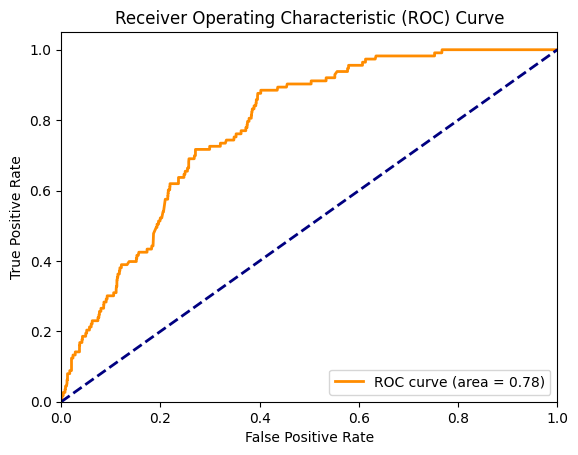

In [20]:
# Step 6: Evaluate the model on the test set
test_predictions = best_model.predict(test_X)
test_probabilities = best_model.predict_proba(test_X)[:, 1]
test_accuracy = accuracy_score(test_Y, test_predictions)
test_roc_auc = roc_auc_score(test_Y, test_probabilities)

print(f"Test set accuracy: {test_accuracy}")
print(f"Test set ROC AUC: {test_roc_auc}")
print(classification_report(test_Y, test_predictions))

# Step 7: Plot the ROC curve
fpr, tpr, _ = roc_curve(test_Y, test_probabilities)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
print(f'Best score: {round(grid_search.best_score_, 4)}')

Best score: 0.7601


In [34]:
#grid_search.best_estimator_.fit(train, target)
predictions = best_model.predict_proba(test)    # predict probabilities
#predictions = best_model.predict(test)         # predict 0 or 1
sample = pd.read_csv(path_sample)
sample['WnvPresent'] = predictions
#sample.to_csv('xgb_predictions2.csv', index=False)



In [35]:
predictions

array([[0.9926895 , 0.00731048],
       [0.9954112 , 0.0045888 ],
       [0.9926895 , 0.00731048],
       ...,
       [0.7901279 , 0.20987214],
       [0.7901279 , 0.20987214],
       [0.7901279 , 0.20987214]], dtype=float32)

In [24]:
from xgboost import XGBClassifier

from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

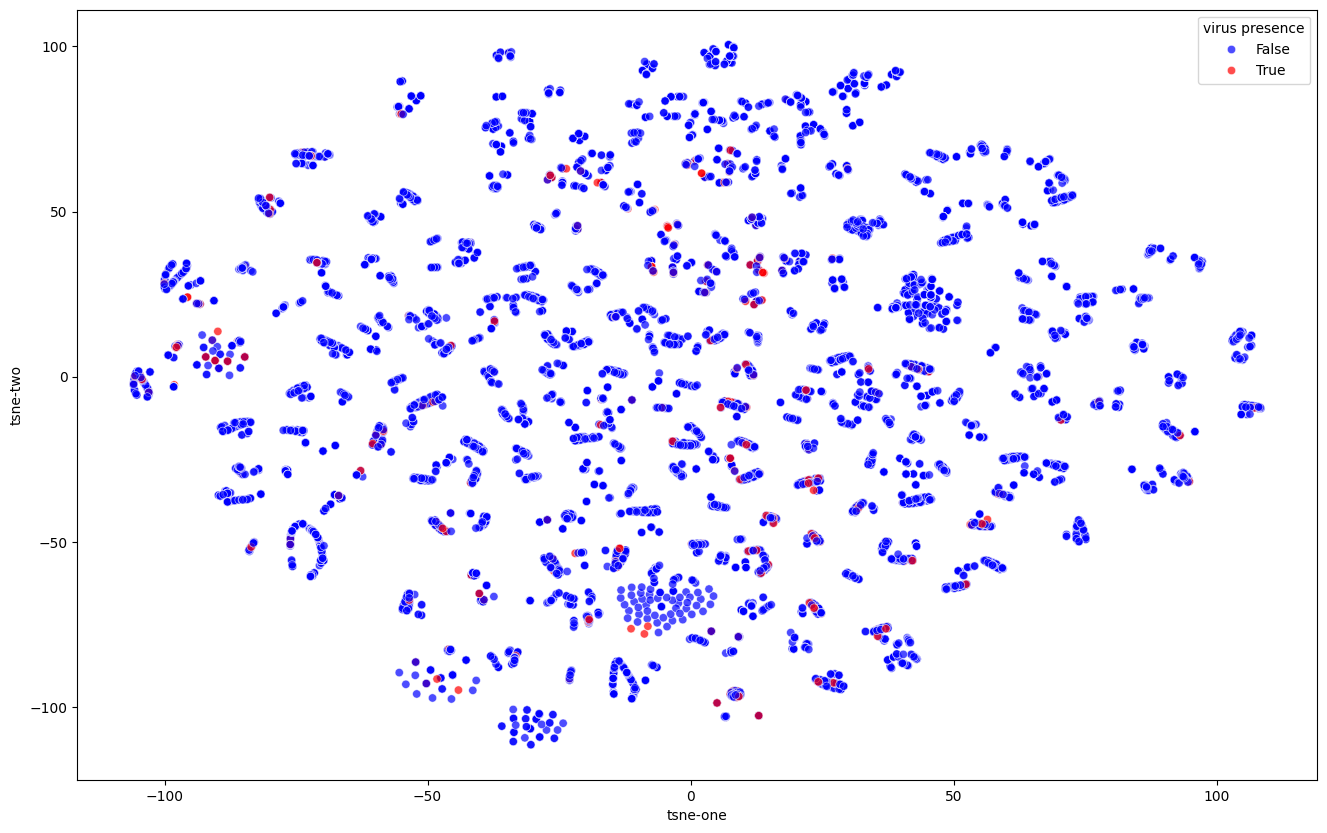

In [25]:
tsne = TSNE(n_components=2)
X = tsne.fit_transform(train)

df = pd.DataFrame()
df['tsne-one'] = X[:,0]
df['tsne-two'] = X[:,1]
df['virus presence']=target.astype('bool')

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one",
    y="tsne-two",
    data=df,
    hue="virus presence",
    palette=['blue', 'red'],
    alpha=0.7
)
plt.show()

In [26]:
train_X, test_X, train_Y, test_Y = train_test_split(train, target, test_size=0.2)

In [27]:
param_grid = {
    'n_estimators': [40, 50, 60],
    'max_depth': [4, 5, 6],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [1, 10],
    'gamma': [0, 0.5],
    'colsample_bytree': [0.8],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier(scale_pos_weight=20)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
model = GridSearchCV(
    param_grid=param_grid,
    estimator=xgb,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

model.fit(train, target)
best_model = model.best_estimator_

Fitting 15 folds for each of 216 candidates, totalling 3240 fits


In [28]:
print(f'Best_model params: {model.best_params_}')
print(f'Best score: {round(model.best_score_, 4)}')

Best_model params: {'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 40, 'reg_alpha': 0.1, 'reg_lambda': 10}
Best score: 0.8362


Test set accuracy: 0.7516650808753568
Test set ROC AUC: 0.9032003417660388
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1994
           1       0.16      0.92      0.28       108

    accuracy                           0.75      2102
   macro avg       0.58      0.83      0.56      2102
weighted avg       0.95      0.75      0.82      2102



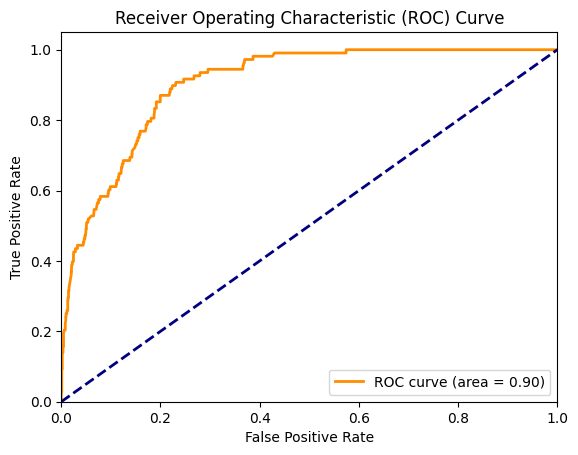

In [29]:
# Step 6: Evaluate the model on the test set
test_predictions = best_model.predict(test_X)
test_probabilities = best_model.predict_proba(test_X)[:, 1]
test_accuracy = accuracy_score(test_Y, test_predictions)
test_roc_auc = roc_auc_score(test_Y, test_probabilities)

print(f"Test set accuracy: {test_accuracy}")
print(f"Test set ROC AUC: {test_roc_auc}")
print(classification_report(test_Y, test_predictions))

# Step 7: Plot the ROC curve
fpr, tpr, _ = roc_curve(test_Y, test_probabilities)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

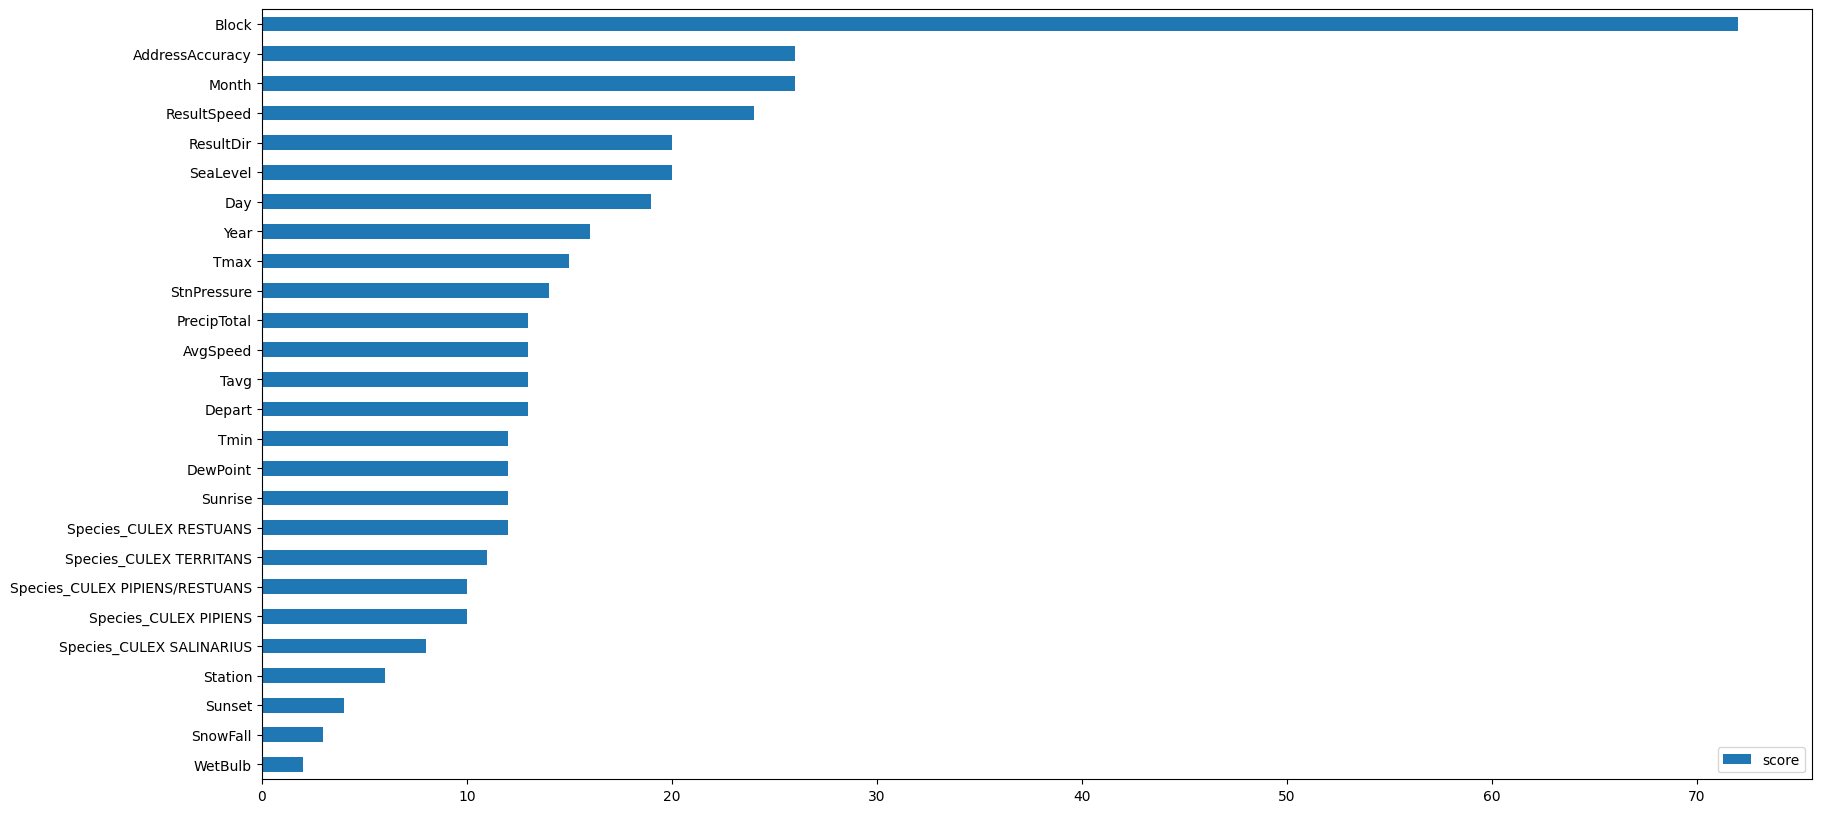

In [30]:
feature_important = best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values("score")
data.plot(kind='barh', figsize = (20,10));

In [ ]:
model.best_estimator_.fit(train, target)
predictions = model.best_estimator_.predict_proba(test)
sample = pd.read_csv(path_sample)
sample['WnvPresent'] = predictions
sample.to_csv('xgb_predictions2.csv', index=False)

In [ ]:
predictions

array([[0.99270433, 0.00729564],
       [0.9954205 , 0.00457946],
       [0.99270433, 0.00729564],
       ...,
       [0.79049855, 0.20950143],
       [0.79049855, 0.20950143],
       [0.79049855, 0.20950143]], dtype=float32)